# Enron Email Dataset

In [1]:
# imports
import os
import matplotlib.pyplot as plt
import pandas as pd
from email.parser import Parser
import pickle
from neo4j import GraphDatabase
import neotime
import pytz, datetime
from dateutil.parser import parse
import csv


## Exploratory Data Analysis

### Initial counting

In [8]:
# Directory structure is:

# maildir
#   - name1
#     - dir1
#       - message1
#       - message2
#     - dir2
#   - name2
#     - dir1
#       - message1


DATA_PATH = './maildir'

accounts = os.listdir(DATA_PATH)
num_accounts = len(accounts)


def count_folders_and_files(path):
    files = folders = 0
    
    for _, dirnames, filenames in os.walk(path):
        files += len(filenames)
        folders += len(dirnames)

    return folders, files

folders, files = count_folders_and_files(DATA_PATH)

print(f'Accounts: {num_accounts}')             
print(f'Folders: {folders}, Files: {files}')

Accounts: 150
Folders: 3499, Files: 517401


Top ten accounts by email_count:

             name  email_count
10     kaminski-v        28465
40     dasovich-j        28234
135        kean-s        25351
73         mann-k        23381
78        jones-t        19950
62   shackleton-s        18687
53       taylor-m        13875
35       farmer-d        13032
19      germany-c        12436
60         beck-s        11830


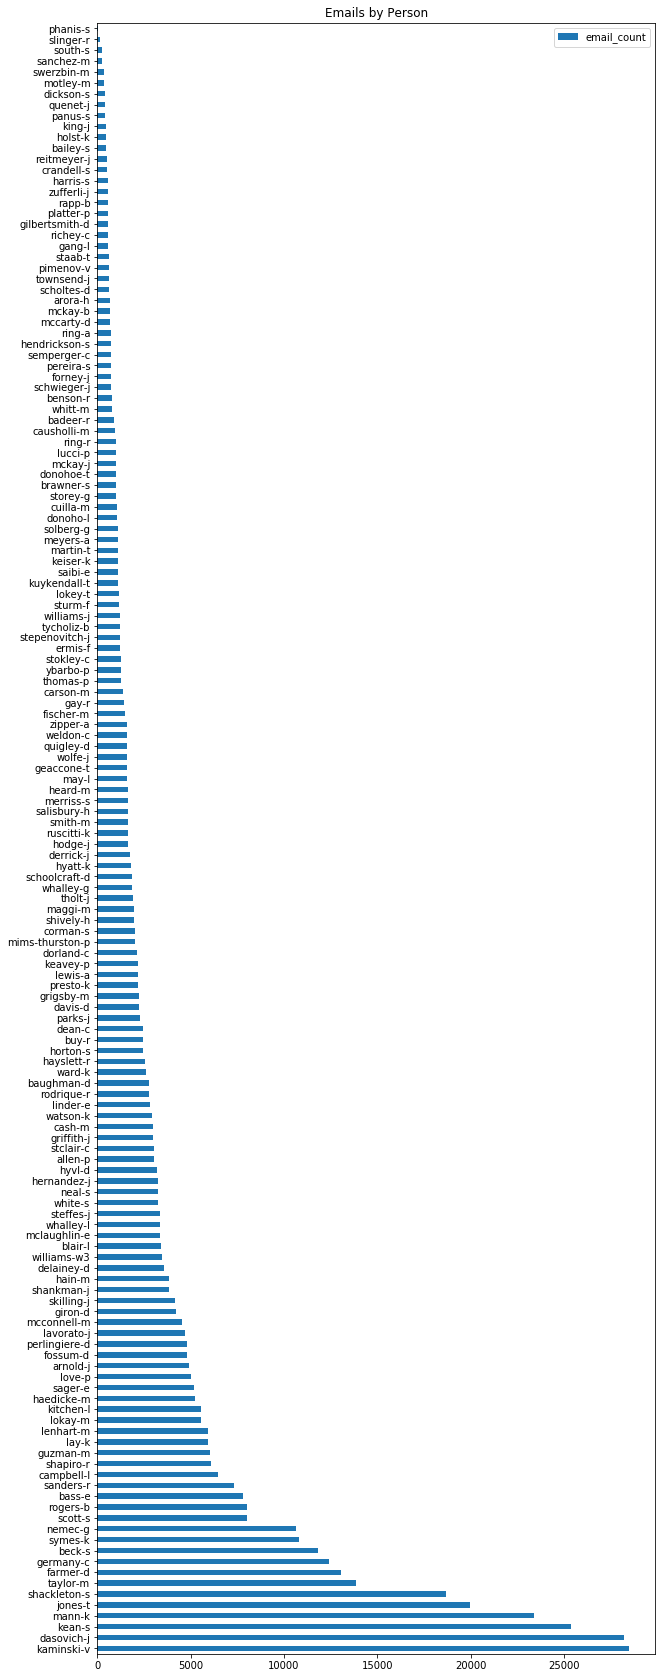

In [9]:
# lets count how many messages per account. 

messages_per_account = {}

for account in accounts: 
    account_path = os.path.join(DATA_PATH, account)
    _, files = count_folders_and_files(account_path)
    messages_per_account[account] = files

email_count_df = pd.DataFrame(list(messages_per_account.items()))    
email_count_df.columns = ['name', 'email_count'] 
email_count_df.sort_values('email_count', ascending = False, inplace = True)
print('Top ten accounts by email_count:\n')
print(email_count_df.head(10))

ax = email_count_df.plot.barh(figsize=(10,30))
ax.set_yticklabels(email_count_df['name'])

plt.title('Emails by Person')
plt.show()


### Observations pt. 1
 - Dataset contains over 517,000 emails distributed across 150 accounts
 - Some accounts have just a few emails `(phanis-s, 35)` while others contain tens of thousands `(kaminski-v, 28465)`
 - These counts do not take into account which emails were sent vs. received and are somewhat dependent on a users email organization habits.
  - Some individuals' directories contain only `inbox` and `deleted_items` (e.g. `harris-s`)
  - Other individuals' directories contains many additional subfolders (e.g. `baughman-d`)
 - To get a better sense for the actual communication patterns we will need to examine the `to:`, `from:`, and `cc:` fields of the emails 
 

In [10]:
# Let's parse some emails!

SAMPLE_MESSAGE_PATH = './maildir/arnold-j/inbox/6.'

with open(SAMPLE_MESSAGE_PATH, "r") as f:
    file_contents = f.read()
    email = Parser().parsestr(file_contents)
    print(email)
    
email.items()


Message-ID: <13556517.1075852726971.JavaMail.evans@thyme>
Date: Wed, 18 Jul 2001 06:59:02 -0700 (PDT)
From: john.griffith@enron.com
To: john.arnold@enron.com
Subject: FW: LNG deal summaries
Cc: denver.plachy@enron.com, eric.boyt@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: denver.plachy@enron.com, eric.boyt@enron.com
X-From: Griffith, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JGRIFFIT>
X-To: Arnold, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Jarnold>
X-cc: Plachy, Denver </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Dplachy>, Boyt, Eric </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Eboyt>
X-bcc: 
X-Folder: \JARNOLD (Non-Privileged)\Arnold, John\Inbox
X-Origin: Arnold-J
X-FileName: JARNOLD (Non-Privileged).pst

John,

Here are the deals that the LNG group are currently working on.  We can discuss whenever you have time, also, if you want Eric Groves to come up to discuss let me know.  Thanks.

John

 -----Original Message-----
From: 	Groves, Eric  
Sent:	Wedn

[('Message-ID', '<13556517.1075852726971.JavaMail.evans@thyme>'),
 ('Date', 'Wed, 18 Jul 2001 06:59:02 -0700 (PDT)'),
 ('From', 'john.griffith@enron.com'),
 ('To', 'john.arnold@enron.com'),
 ('Subject', 'FW: LNG deal summaries'),
 ('Cc', 'denver.plachy@enron.com, eric.boyt@enron.com'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('Bcc', 'denver.plachy@enron.com, eric.boyt@enron.com'),
 ('X-From', 'Griffith, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=JGRIFFIT>'),
 ('X-To', 'Arnold, John </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Jarnold>'),
 ('X-cc',
  'Plachy, Denver </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Dplachy>, Boyt, Eric </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Eboyt>'),
 ('X-bcc', ''),
 ('X-Folder', '\\JARNOLD (Non-Privileged)\\Arnold, John\\Inbox'),
 ('X-Origin', 'Arnold-J'),
 ('X-FileName', 'JARNOLD (Non-Privileged).pst')]

In [11]:
# Multiple recipients are denoted as a single string with commas, will need to split.
email['cc'].split(', ')

['denver.plachy@enron.com', 'eric.boyt@enron.com']

### Parse all of the files!

In [ ]:
PICKLE_FILENAME = 'email_data.pkl'

# How many unique email addresses are in the dataset?
# How should we represent the data?
#  - Sparse matrix of to/from counts
#  - Relational tables (Tables: emails, users, recipients)
#    - Dataframe
#    - RDBMS 
#  - Graph DB (Nodes: users, messages // Edges: Sent, Recieved (to/cc/bcc))


# # First lets just put the data into a dict w/ message-id as the key
# i = 0
# failed = 0
# email_data = {}

# for path, dirnames, filenames in os.walk(DATA_PATH):
#     for filename in filenames:
#         email_path = os.path.join(path, filename)
#         with open(email_path, "r") as f:
#             try:
#                 file_contents = f.read()
#                 email = Parser().parsestr(file_contents)
#                 email_data[email['Message-ID']] = {
#                     'to': email['To'].replace('\n\t', '').split(', ') if email['To'] else None,
#                     'from': email['From'].replace('\n\t', '').split(', ') if email['From'] else None,
#                     'cc': email['Cc'].replace('\n\t', '').split(', ') if email['Cc'] else None,
#                     'bcc': email['Bcc'].replace('\n\t', '').split(', ') if email['Bcc'] else None,
#                     'date': email['Date'],
#                     'subject': email['subject']
#                 }
#             except:
#                 failed += 1
#                 print('Failed: ', failed)
        
#             i += 1
#             if i % 10000 == 0:
#                 print(f'{i}...')

# print('Read: ', i)
# print('Failed: ', failed)
    
# # save to file        
# f = open(PICKLE_FILENAME,'wb')
# pickle.dump(email_data,f)
# f.close()


# read python dict back from the file
pkl_file = open(PICKLE_FILENAME, 'rb')
email_data = pickle.load(pkl_file)
pkl_file.close()

In [13]:
TRANSMISSION_TYPES = [
    'from',
    'to',
    'cc',
    'bcc'
]

base_person = {
    'from': 0,
    'to': 0,
    'cc': 0,
    'bcc': 0
}

In [14]:
people = {}

def count_message_transmission(data, transmission_type):
    for message_id, email in data.items():
        try:
            for person in email[transmission_type]:
                if not person in people:
                    people[person] = base_person.copy()
                people[person][transmission_type] += 1
        except:
            pass


for transmission_type in TRANSMISSION_TYPES:
    print(f'Counting "{transmission_type}" messages...')
    count_message_transmission(email_data, transmission_type)

Counting "from" messages...
Counting "to" messages...
Counting "cc" messages...
Counting "bcc" messages...


In [15]:
people_df = pd.DataFrame.from_dict(people, orient='index').reset_index().rename(columns={'index': 'address'})
# dropped bcc because it is identical to cc field...
people_df.drop(columns=['bcc'], inplace=True)
people_df['inbound'] = people_df['to'] + people_df['cc']
people_df['total'] = people_df['from'] + people_df['inbound']
people_df.sort_values(by='total', ascending=False, inplace=True)

def is_enron_address(address):
    return address[-10:] == '@enron.com'

people_df['is_enron_address'] = people_df['address'].apply(is_enron_address)

print('Total unique addressess:', people_df.shape[0])

print('\n-------------\n')

print('Internal vs. external:\n\n', people_df.groupby('is_enron_address').count()[['total']])

print('\n-------------\n')

print('Sums:\n\n', people_df.drop(columns=['address']).sum())


Total unique addressess: 87040

-------------

Internal vs. external:

                   total
is_enron_address       
False             55003
True              32037

-------------

Sums:

 from                 517311.0
to                  3126880.0
cc                   562688.0
inbound             3689568.0
total               4206879.0
is_enron_address      32037.0
dtype: float64


### Observations pt. 2
 - Cc and Bcc fields contain itentical addresses. X-cc and X-bcc fields do not, but the addresses are much less nicely formatted. For now let's will ignore bcc.
 - There are 87040 unique email addresses in the dataset
  - 32037 are `@enron.com` addresses
  - 55003 are not `@enron.com` addresses

### Load into a graph database

#### Schema:

Nodes:
- email
 - message_id
 - timestamp
 - subject
- person
 - email_address

Relationships:
- person - [sent|received_to|received_cc] -> email 

- email - [replies_to|forwards_from] -> email (not sure if this will be possible given the data)


In [15]:
class EmailGraphDb(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

    def run_cypher_string(self, cypher_string, parameters={}):
        with self._driver.session() as session:
            return session.run(cypher_string, parameters)

    def add_person(self, email_address):
        parameters = {
            "props": {
                "email_address": email_address
            }
        }

        cypher_string = f'''        
            CREATE (
                n:Person $props
            )
            '''
        self.run_cypher_string(cypher_string, parameters)

    def add_email(self, message_id, timestamp, subject):
        parameters = {
            "sent_at": timestamp,
            "message_id": message_id,
            "subject": subject
        }

        cypher_string = f'''        
            CREATE (
                n:Email {{
                    sent_at: datetime( $sent_at ),
                    message_id: $message_id ,
                    subject: $subject 
                }}
            )
            '''
        self.run_cypher_string(cypher_string, parameters)

    def add_person_email_relationship(self, email_address, message_id, transmision_type):
        relationship_types = {
            'from': 'sent',
            'to': 'received_to',
            'cc': 'received_cc'
        }

        relationship_type = relationship_types[transmision_type]

        parameters = {
            "email_address": email_address,
            "message_id": message_id
        }

        cypher_string = f'''        
            MATCH (p:Person),(e:Email)
            WHERE p.email_address = $email_address AND e.message_id = $message_id
            CREATE (p)-[r: {relationship_type} ]->(e)
            '''
        self.run_cypher_string(cypher_string, parameters)


enron_neo_db = EmailGraphDb('bolt://localhost:7687', 'neo4j', 'admin')

In [17]:
TRANSMISSION_TYPES = [
    'from',
    'to',
    'cc'
]

# First lets generate all of the person node info
unique_email_addresses = set()

for _, email in email_data.items():
    for transmission_type in TRANSMISSION_TYPES:
        try:
            for email_address in email[transmission_type]:
                unique_email_addresses.add(email_address)
        except:
            pass


In [ ]:
index_queries = [
    'CREATE CONSTRAINT ON (p:Person) ASSERT p.email_address IS UNIQUE;',
    'CREATE CONSTRAINT ON (e:Email) ASSERT e.message_id IS UNIQUE;',
    'CREATE INDEX ON :Email(sent_at);'
]

for query in index_queries:
    print('\nRunning: \n\n', query)
    enron_neo_db.run_cypher_string(query)


In [18]:
for idx, email_address in enumerate(unique_email_addresses):
    enron_neo_db.add_person(email_address)
    if idx % 10000 == 0:
        print(f'{idx} Person nodes created...')

0 Person nodes created...
10000 Person nodes created...
20000 Person nodes created...
30000 Person nodes created...
40000 Person nodes created...
50000 Person nodes created...
60000 Person nodes created...
70000 Person nodes created...
80000 Person nodes created...


In [19]:
for message_id, email in email_data.items():
    python_datetime = parse(email['date']).astimezone(pytz.utc)
    neotime_datetime = neotime.DateTime(python_datetime.year,
                                        python_datetime.month,
                                        python_datetime.day,
                                        python_datetime.hour,
                                        python_datetime.minute)
    enron_neo_db.add_email(message_id, neotime_datetime, email['subject'])
    for transmission_type in TRANSMISSION_TYPES:
        try:
            for email_address in email[transmission_type]:
                enron_neo_db.add_person_email_relationship(email_address,
                                                           message_id,
                                                           transmission_type)
        except:
            pass

This approach was convenient and would be good for creating individual nodes/relationships, but is slow for trying to import the entire dataset because it making a separate request to create each node and relationship.

It took ~4.5 hours (running on my 2012 Macbook Air) to complete.

--

This [talk](https://neo4j.com/blog/bulk-data-import-neo4j-3-0/) gives a good summary of how to use the `LOAD CSV` for moderately sized datasets (<10M rows) and `neo4j-import` for large datasets.

Lets use `LOAD CSV` to try and speed things up:

### Create the CSVs

In [90]:
# Lets create 3 csv files: 
#  - persons
#  - messages
#  - recipients

persons_columns = ['email_address']
with open('./neo4j/import/persons.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(persons_columns)
    for email_address in unique_email_addresses:
        writer.writerow([email_address.replace('"', '\'')])


In [91]:
TRANSMISSION_TYPES = [
    'from',
    'to',
    'cc'
]

messages_file = open('./neo4j/import/messages.csv', 'w')
messages_columns = ['message_id', 'sent_at:datetime', 'subject']
messages_writer = csv.writer(messages_file)
messages_writer.writerow(messages_columns)

recipients_file = open('./neo4j/import/recipients.csv', 'w')
recipients_columns = ['message_id', 'email_address', 'transmission_type']    
recipients_writer = csv.writer(recipients_file)
recipients_writer.writerow(recipients_columns)

for message_id, email in email_data.items():
    python_datetime = parse(email['date']).astimezone(pytz.utc)
    messages_writer.writerow([message_id, python_datetime.isoformat(), email['subject'].replace('"', '\'').replace('\\', '\\\\')])
    for transmission_type in TRANSMISSION_TYPES:
        try:
            for email_address in email[transmission_type]:
                recipients_writer.writerow([message_id, email_address.replace('"', '\''), transmission_type])
        except:
            pass
    
messages_file.close()
recipients_file.close()

### Load the data with CYPHER commands:

In [94]:
index_queries = [
    'CREATE CONSTRAINT ON (p:Person) ASSERT p.email_address IS UNIQUE;',
    'CREATE CONSTRAINT ON (e:Email) ASSERT e.message_id IS UNIQUE;',
    'CREATE INDEX ON :Email(sent_at);'
]

for query in index_queries:
    print('\nRunning: \n\n', query)
    enron_neo_db.run_cypher_string(query)
    


Running: 

 CREATE CONSTRAINT ON (p:Person) ASSERT p.email_address IS UNIQUE;

Running: 

 CREATE CONSTRAINT ON (e:Email) ASSERT e.message_id IS UNIQUE;

Running: 

 CREATE INDEX ON :Email(sent_at);


In [ ]:
persons_query = '''
    USING PERIODIC COMMIT 1000
    LOAD CSV WITH HEADERS FROM "file:///persons.csv" AS row
    MERGE (p:Person {email_address: row.email_address})
    SET p.email_address = row.email_address;
    '''

emails_query = '''
    USING PERIODIC COMMIT 1000
    LOAD CSV WITH HEADERS FROM "file:///messages.csv" AS row
    MERGE (e:Email {message_id: row.message_id})
    SET 
        e.message_id = row.message_id,
        e.sent_at = row.sent_at,
        e.subject = row.subject;
    '''

recipients_query = '''
    USING PERIODIC COMMIT 1000
    LOAD CSV WITH HEADERS FROM "file:///recipients.csv" AS row
    MATCH (p:Person {email_address: row.email_address})
    MATCH (e:Email {message_id: row.message_id})
    WITH row, p, e, CASE row.transmission_type WHEN "from" THEN [1] ELSE [] END AS from
    WITH row, p, e, from, CASE row.transmission_type WHEN "to" THEN [1] ELSE [] END AS to
    WITH row, p, e, from, to, CASE row.transmission_type WHEN "cc" THEN [1] ELSE [] END AS cc
    FOREACH ( _ IN from | MERGE (p)-[:sent]->(e) )
    FOREACH ( _ IN to  | MERGE (p)-[:received_to]->(e) )
    FOREACH ( _ IN cc | MERGE (p)-[:received_cc]->(e) );
    '''

with enron_neo_db._driver.session() as session:
    session.write_transaction()